# Training Deep Q-Learning Agent

---

In this notebook, you can train **Deep Q-Learning** (**DQN**) and **Double DQN** (**DDQN**) Agent which walks around in the banana catching game simulator(Unity ML-Agents environment). This notebook is the first project of the [Deep Reinforcement Learning Nanodegree (DRLND)](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). This notebook is modified from the original verison on [Udacity Github Repository](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation)

***Before you use this notebook, read README.md and check your python environment satisfies [Udacity DRLND prerequisite](https://github.com/udacity/deep-reinforcement-learning/#dependencies) and place pre-compiled game executable on an adequate directory.***
This notebook is checked on Win10 + Anaconda 5.2 (Python 3.6), but can be executed on the other environment.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch

Next, start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded and extracted. When you extracted it on `bin/` directory,

- **Mac**: `"bin/Banana.app"`
- **Windows** (x86): `"bin/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"bin/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"bin/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"bin/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"bin/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"bin/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="bin/Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="bin/Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Launch the Agent
Let's launch the agent! You can use next two types of agents.
- ``DQNAgent`` : Deep Q-Learning(DQN) Agent 
- ``DDQNAgent`` : Double DQN (DDQN) Agent

Because Double DQN overcome the tendency which DQN overestimates the reward of action,
``DDQNAgent`` can achieve better performance then ``DQNAgent`` on average.
Before run it, recommended to change values of next hyperparameters to make agent more clever.

- ``hidden_layers`` (list of int)
    - Specify the structure of Neural Network (In: state, Out: estimated reward of each action)
    - If you set ``[64, 32]``:
        - Input : state
        - Hidden Layer 1 : 64 nodes
        - Hidden Layer 2 : 32 nodes
        - Output : estimated reward of each action
- ``tau`` (float between 0 and 1)
    - update rate by soft update of target model
    - updated slower if you set smaller value.
- ``learning_rate`` (float)
    - learning_rate used by Adam.

In [4]:
from dqn import DDQNAgent
agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=123,
                  hidden_layers=[32, 8], tau=1e-3, learning_rate=5e-4)

Before you train the agent, check how it performs in the simulation ***without training***.  
You can see that it makes almost random decision.

In [5]:
# reset environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

# run without training
for j in range(20):
    # select action
    action = agent.act(state).astype(int)
    env_info = env.step(action)[brain_name]
    
    # get the next state
    state = env_info.vector_observations[0]
    # get the reward
    reward = env_info.rewards[0]
    # see if episode has finished
    done = env_info.local_done[0]
    if done:
        break 

### 4. Training
This is time consuming task. When Agent use GPU if your environment has it.

In [6]:
import numpy as np
from collections import deque

In [7]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train Agent by playing simulator
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [8]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
scores = train()

Episode 100	Average Score: 0.57
Episode 200	Average Score: 3.04
Episode 300	Average Score: 7.39
Episode 400	Average Score: 9.66
Episode 500	Average Score: 12.53
Episode 524	Average Score: 13.01
Environment solved in 424 episodes!	Average Score: 13.01


### 5. Check score history
Plot the time series of scores during training.
Plotted figure is save to `result_score.jpg`

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

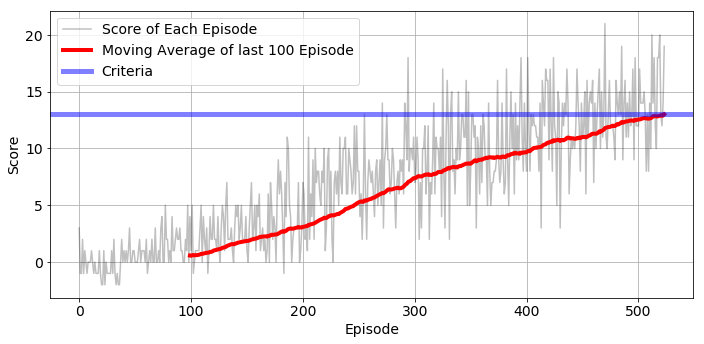

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

scores_rolling = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(scores_rolling, "-", c="red", linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(13, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score of Each Episode", "Moving Average of last 100 Episode", "Criteria"])

fig.tight_layout()
fig.savefig("result_score.jpg")

### 6. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
    
    for j in range(200):
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        done = env_info.local_done[0]                  # see if episode has finished
        if done:
            break 

When finished, you can close the environment.

In [ ]:
env.close()